## Preprocess with all variables necessary

In [2]:
from cbrain.imports import *
from cbrain.data_generator import *
from cbrain.utils import limit_mem
# Otherwise tensorflow will use ALL your GPU RAM for no reason
limit_mem()

Using TensorFlow backend.
/home/s/S.Rasp/miniconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [1]:
!rm /local/S.Rasp/preprocessed_data/32_col_mp_3d*

In [3]:
%cd ../../

/home/s/S.Rasp/repositories/CBRAIN-CAM


In [10]:
!python cbrain/preprocess_aqua.py \
--config pp_config/32col_mp_ref.yml \
--aqua_names '*.h1.0000-*-01-*' \
--out_pref 32_col_mp_3d_train

Time checkpoint reading data: 0.46 s
Number of time steps: 576
Cut time steps: [ 47  95 143 191 239 287 335 383 431 479 527]
Cut time steps: [ 47  95 143 191 239 287 335 383 431 479 527]
Time checkpoint create datasets: 0.57 s
Time checkpoint reshape and rechunk: 0.75 s
Compute means and stds
Saving normalization file: /local/S.Rasp/preprocessed_data/32_col_mp_3d_train_norm.nc
Time checkpoint normalization arrays: 51.32 s
Time checkpoint rechunk and ds: 51.55 s
Save features: /local/S.Rasp/preprocessed_data/32_col_mp_3d_train_features.nc
Save targets: /local/S.Rasp/preprocessed_data/32_col_mp_3d_train_targets.nc
Total time: 86.75 s


In [11]:
DATADIR = '/local/S.Rasp/preprocessed_data/'

In [12]:
!ls $DATADIR

32_col_engy_ess_1y_train_features.nc
32_col_engy_ess_1y_train_shuffle_features.nc
32_col_engy_ess_1y_train_shuffle_targets.nc
32_col_engy_ess_1y_train_targets.nc
32_col_engy_ess_3d_train_features.nc
32_col_engy_ess_3d_train_norm.nc
32_col_engy_ess_3d_train_shuffle_features.nc
32_col_engy_ess_3d_train_shuffle_targets.nc
32_col_engy_ess_3d_train_targets.nc
32_col_engy_ess_3d_valid_features.nc
32_col_engy_ess_3d_valid_targets.nc
32_col_mp_3d_train_features.nc
32_col_mp_3d_train_norm.nc
32_col_mp_3d_train_targets.nc
fbp_engy_ess_ref_train_fullyear_shuffle_features.nc
fbp_engy_ess_ref_train_fullyear_shuffle_targets.nc
fbp_engy_ess_ref_train_sample1_norm_big_fluxes2.nc
fbp_engy_ess_ref_train_sample1_norm_big_fluxes.nc
fbp_engy_ess_ref_train_sample1_norm.nc
fbp_engy_ess_ref_train_sample1_norm_small_fluxes2.nc
fbp_engy_ess_ref_train_sample1_norm_small_fluxes.nc
fbp_engy_ess_train_fullyear_norm.nc
fbp_engy_ess_train_sample1_norm.nc
fbp_engy_ess_valid_fullyear_features.nc
fbp_engy_ess_valid_full

TODO: Shuffle and validation

## Create data generator and produce data sample

```
P = P0 * hyai + PS * hybi
```
This is to compute the pressure levels for one column. The coefficients hyai and hybi are constatnt, onle PS is variable.

### How to change the normalization of the outputs.

In [13]:
import xarray as xr

In [14]:
ds = xr.open_dataset(DATADIR + '32_col_mp_3d_train_norm.nc')

In [15]:
ds

<xarray.Dataset>
Dimensions:              (feature_lev: 154, target_lev: 125)
Coordinates:
  * feature_lev          (feature_lev) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 ...
  * target_lev           (target_lev) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 ...
Data variables:
    feature_means        (feature_lev) float32 ...
    feature_stds         (feature_lev) float32 ...
    feature_mins         (feature_lev) float32 ...
    feature_maxs         (feature_lev) float32 ...
    target_means         (target_lev) float32 ...
    target_stds          (target_lev) float32 ...
    target_mins          (target_lev) float32 ...
    target_maxs          (target_lev) float32 ...
    feature_names        (feature_lev) object ...
    target_names         (target_lev) object ...
    feature_stds_by_var  (feature_lev) float32 ...
    target_conv          (target_lev) float32 ...
Attributes:
    log:      \n    Time: 2019-01-15T14:08:44\n\n    Executed command:\n\n   ...

In [16]:
#ds['target_conv'] = some_operation_on_target_conv()  
# Some vector with length 125

In [17]:
ds.target_names[:5]

<xarray.DataArray 'target_names' (target_lev: 5)>
array(['PHQ_lev00', 'PHQ_lev01', 'PHQ_lev02', 'PHQ_lev03', 'PHQ_lev04'],
      dtype=object)
Coordinates:
  * target_lev  (target_lev) int64 0 1 2 3 4

In [18]:
ds.close()

### Create data generator

In [19]:
train_gen_obj = DataGenerator(
    data_dir=DATADIR, 
    feature_fn='32_col_mp_3d_train_features.nc',
    target_fn='32_col_mp_3d_train_targets.nc',
    batch_size=512,
    norm_fn='32_col_mp_3d_train_norm.nc',
    fsub='feature_means',   # Subtracct the mean
    fdiv='feature_stds_by_var',    # Then divide by Std
    tmult='target_conv',    # For targets/output: use values from preprocess_aqua.
    shuffle=True,
)

Generator will have 4620288 samples in 9024 batches
Features have shape 154; targets have shape 125


In [20]:
gen = train_gen_obj.return_generator()

In [21]:
x, y = next(gen)

In [22]:
x.shape, y.shape

((512, 154), (512, 125))

## Simple neural network

In [23]:
from keras.layers import *
from keras.models import *

In [24]:
inp = Input(shape=(154,))
act = Dense(124, activation='relu')(inp)
out = Dense(125)(act)
model1 = Model(inputs=inp, outputs=out)

In [25]:
model1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 154)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 124)               19220     
_________________________________________________________________
dense_2 (Dense)              (None, 125)               15625     
Total params: 34,845
Trainable params: 34,845
Non-trainable params: 0
_________________________________________________________________


In [26]:
model1.compile('adam', loss='mse')

In [ ]:
model1.fit_generator(gen, train_gen_obj.n_batches)

In [ ]:
preds = model1.predict_on_batch(x)

In [ ]:
preds.shape

In [ ]:
plt.plot(preds[0])
plt.plot(y[0])

## Implement energy conservation layer

### softplus on q

In [27]:
import keras.backend as K

In [28]:
class PhysicalConstraintLayer(Layer):
    
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        
    def build(self, input_shape):
        super().build(input_shape)  # Be sure to call this somewhere!
        
    def call(self, x):
        # x will be [n_samples, 125] with 
        # [QBP, QCBP, QIBP, TPHYSTND, FSNT, FSNS, FLNT, FLNS, PRECT]
        x_q = x[:, :90]
        x_remain = x[:, 90:]
        
        # softplus on x_q
        x_q = K.softplus(x_q)
        
        # Concat them back together
        out = K.concatenate([x_q, x_remain])
        
        return out
    
    def compute_output_shape(self, input_shape):
        return input_shape

In [29]:
m = Sequential(
    [PhysicalConstraintLayer(input_shape=(125,))]
)

In [30]:
m.compile('adam', 'mse')

In [31]:
m.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
physical_constraint_layer_1  (None, 125)               0         
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________


In [32]:
x_rand = np.random.rand(1, 125)-0.5

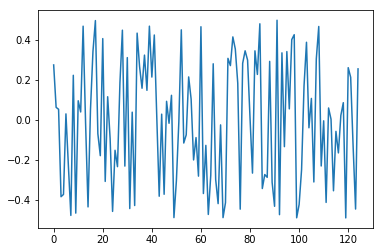

In [33]:
plt.plot(x_rand[0])

In [34]:
preds = m.predict_on_batch(x_rand)

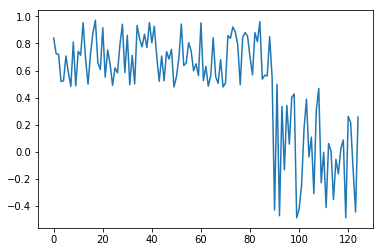

In [35]:
plt.plot(preds[0])

### convert q to d_t

In [43]:
ds = xr.open_dataset(DATADIR + '32_col_mp_3d_train_norm.nc')

In [46]:
fsub = ds.feature_means.values
fdiv = ds.feature_stds_by_var.values

In [47]:
ds.close()

In [110]:
class PhysicalConstraintLayer(Layer):
    
    def __init__(self, fsub, fdiv, dt=30*60, **kwargs):
        self.fsub = fsub 
        self.fdiv = fdiv
        self.dt = dt
        super().__init__(**kwargs)
        
    def build(self, input_shape):
        super().build(input_shape)  # Be sure to call this somewhere!
        
    def call(self, arrs):
        # arrs (for arrays) is a list with 
        # [inputs and the output of the previous layer]
        # inputs will be [n_sample, 154] with
        # [QBP, QCBP, QIBP, TBP, VBP, PS, SOLIN, SHFLX, LHFLX]
        # outputs will be [n_samples, 125] with 
        # [QAP, QCAP, QIAP, TPHYSTND, FSNT, FSNS, FLNT, FLNS, PRECT]
        
        # Split
        inp, act = arrs
        
        # SOFTPLUS PART
        qap = act[:, :90]
        remain = act[:, 90:]
        # softplus on x_q
        qap = K.softplus(qap)
        
        # UNNORMALIZE INP
        inp = inp * self.fdiv + self.fsub
        
        # COMPUTE TEMPORAL DIFFERENCES
        qbp = inp[:, :90]
        L_V = 2.501e6 ; L_I = 3.337e5; L_S = L_V + L_I
        diff = (qap - qbp) / self.dt#  * L_S
        # Not so sure what this should be...
        
        # Concat out
        out = K.concatenate([diff, remain])
        
        return out
    
    def compute_output_shape(self, input_shape):
        return input_shape[1]

In [111]:
inp = Input(shape=(154,))
act = Dense(256, activation='relu')(inp)
for i in range(4):
    act = Dense(256, activation='relu')(act)
act = Dense(125, activation='relu')(act)
out = PhysicalConstraintLayer(
    input_shape=(125,), fsub=fsub, fdiv=fdiv
)([inp, act])
m = Model(inputs=inp, outputs=out)

In [112]:
m.compile('adam', 'mse')

In [118]:
m.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           (None, 154)          0                                            
__________________________________________________________________________________________________
dense_19 (Dense)                (None, 256)          39680       input_13[0][0]                   
__________________________________________________________________________________________________
dense_20 (Dense)                (None, 256)          65792       dense_19[0][0]                   
__________________________________________________________________________________________________
dense_21 (Dense)                (None, 256)          65792       dense_20[0][0]                   
__________________________________________________________________________________________________
dense_22 (

In [119]:
m.fit_generator(gen, train_gen_obj.n_batches, epochs=1)

Epoch 1/1
9024/9024 [==============================] - 76s 8ms/step - loss: 856194.9282


In [115]:
preds = m.predict_on_batch(x)

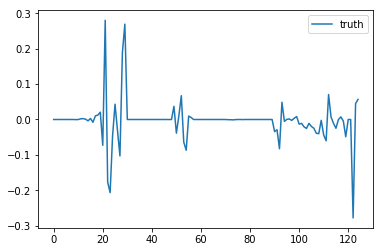

In [117]:
plt.plot(preds[0], label='nn')
plt.plot(y[0], label='truth')
plt.legend();

## Get output of intermediate layer

In [121]:
# Create a new model just for illustration, this is not a functional model!
inp = Input(shape=(154,))
act = Dense(125, activation='relu')(inp)
phy = PhysicalConstraintLayer(
    input_shape=(125,), fsub=fsub, fdiv=fdiv
)([inp, act])
out = Dense(125)(phy)
m = Model(inputs=inp, outputs=out)

In [122]:
m.compile('adam', 'mse')

In [123]:
m.fit_generator(gen, train_gen_obj.n_batches, epochs=1)

Epoch 1/1
9024/9024 [==============================] - 47s 5ms/step - loss: 8010.4889


In [124]:
m.layers

In [146]:
m.layers[1].get_weights()[0][0][0]

-0.050036915

In [147]:
# Now get output of the trained model for the phy layer.
inter_model = Model(inputs=[inp], outputs=phy)

In [150]:
inter_model.layers[1].get_weights()[0][0][0]

-0.050036915

In [148]:
# Get a batch of data
x, y = next(gen)

In [149]:
inter_model.predict(x)

array([[1.0915890e+03, 1.0915890e+03, 1.0915891e+03, ..., 9.4080812e-01,
        0.0000000e+00, 2.2885585e-01],
       [1.0915890e+03, 1.0915890e+03, 1.0915891e+03, ..., 1.0180218e+00,
        0.0000000e+00, 0.0000000e+00],
       [1.0915890e+03, 1.0915889e+03, 1.0915891e+03, ..., 1.9776658e+00,
        0.0000000e+00, 6.8907785e-01],
       ...,
       [1.0915889e+03, 1.0915889e+03, 1.0915891e+03, ..., 4.9074397e+00,
        0.0000000e+00, 0.0000000e+00],
       [1.0915889e+03, 1.0915889e+03, 1.0915891e+03, ..., 6.1845980e+00,
        0.0000000e+00, 1.6628009e-01],
       [1.0915889e+03, 1.0915889e+03, 1.0915891e+03, ..., 5.9749470e+00,
        0.0000000e+00, 0.0000000e+00]], dtype=float32)